In [0]:
#Importing Datasets
data2015_1 = spark.read.csv('dbfs:/FileStore/yellow_tripdata_2015_01.csv', header=True, inferSchema=True)

In [0]:
#Displaying Schema
print("Schema for 2015_1")
data2015_1.printSchema()

Schema for 2015_1
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [0]:
columns = [
    'VendorID', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 
    'RateCodeID', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 
    'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 
    'improvement_surcharge', 'total_amount'
]

dataset = data2015_1
print("Basic statistics for data2015_1:")
pddf = dataset.select(columns).describe().toPandas()
pddf.set_index('summary')
pddf



Basic statistics for data2015_1:


,summary,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,count,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748983,12748986
1,mean,1.5214373127400094,1.6814908260154964,13.459129611562718,-72.56183777902534,39.97282304763482,1.0369007386156044,-72.60903923063492,39.9996144802455,1.3867115392549652,11.905659425776989,0.30827895724412907,0.4977986092384132,1.8538136460419994,0.24349839430352666,0.28314307893811447,15.108294537401271
2,stddev,0.4995402498256225,1.3379235172874737,9844.094218468374,10.125103592972911,5.5786905190884,0.6732239779497589,9.96603703803103,5.48774188661968,0.4988610635053929,10.302537135952232,0.5916643112912818,0.0353422867098315,1106.4323141838747,1.5271714003797854,0.06908632935830779,1106.503246710499
3,min,1,0,0.0,-121.92581176757812,0.0,1,-740.1666870117188,-9.029156684875488,1,-450.0,-79.0,-0.5,-92.42,-26.0,0.0,-450.3
4,max,2,9,1.54200045E7,78.66265106201172,404.70001220703125,99,85.2740249633789,459.5333251953125,5,4008.0,999.99,0.5,3950588.8,1450.09,0.3,3950611.6


In [0]:
from pyspark.sql.functions import col,unix_timestamp
cleancolumns = ["fare_amount","trip_distance","passenger_count"]

#Cleaning Columns
data2015_1c = data2015_1.na.drop(subset=cleancolumns)
data2015_1c = data2015_1c.filter((data2015_1c['fare_amount'] >= 0) & (data2015_1c['trip_distance'] > 0))
data2015_1c = data2015_1c.withColumn('tpep_pickup_datetime', col('tpep_pickup_datetime').cast('timestamp')) \
.withColumn('tpep_dropoff_datetime', col('tpep_dropoff_datetime').cast('timestamp'))
#Refactoring
data2015_1c = data2015_1c.withColumn('trip_duration', (unix_timestamp('tpep_dropoff_datetime') - unix_timestamp('tpep_pickup_datetime')) / 60)
data2015_1c = data2015_1c.withColumn('trip_speed', col('trip_distance') / (col('trip_duration') / 60))



In [0]:
from pyspark.sql.functions import avg,hour,count
from pyspark.sql import DataFrame

# Load the dataset
dta = data2015_1c

# Displays Average fare and trip distance
print("Average fare and trip distance for data2015_1:")
dta.groupBy('passenger_count').agg(
    avg('fare_amount').alias('avg_fare_amount'),
    avg('trip_distance').alias('avg_trip_distance')
).show()

# Displays Busiest times for pickup
print("Busiest times of day for pickups in data2015_1:")
dta.withColumn('pickup_hour', hour('tpep_pickup_datetime')) \
    .groupBy('pickup_hour') \
    .agg(count('*').alias('pickup_count')) \
    .orderBy('pickup_count', ascending=False) \
    .show()

# Displays Longitude + Latitude numbers for the highest average amount
print("Neighbourhoods with highest average fare amount in data2015_1:")
dta.groupBy('pickup_latitude', 'pickup_longitude') \
    .agg(avg('fare_amount').alias('avg_fare_amount')) \
    .orderBy('avg_fare_amount', ascending=False) \
    .show()



Average fare and trip distance for data2015_1:
+---------------+------------------+------------------+
|passenger_count|   avg_fare_amount| avg_trip_distance|
+---------------+------------------+------------------+
|              1|11.743624039522025|14.936129414437087|
|              6| 11.79888014741581| 2.797232577128477|
|              3| 12.07371162571449| 2.865545589154936|
|              5|11.964216065900473| 2.865003846303171|
|              4|12.142540608079981|2.8842209793538394|
|              2|12.363818691252265|  18.1272765480294|
|              0|10.589636363636366|2.2844344328238133|
|              9| 74.41666666666667|13.326666666666668|
|              8|              33.5| 7.263333333333333|
|              7|12.428571428571429|3.3000000000000003|
+---------------+------------------+------------------+

Busiest times of day for pickups in data2015_1:
+-----------+------------+
|pickup_hour|pickup_count|
+-----------+------------+
|         19|      800985|
|         18

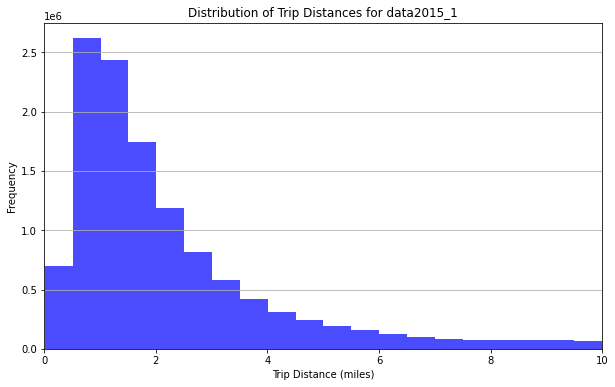

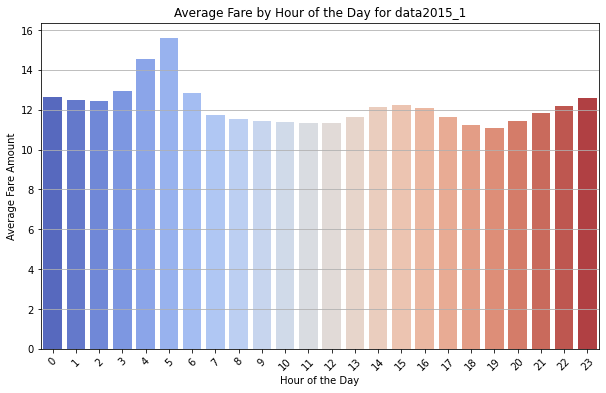

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Displaying Distribution of Trip Distances
trip_distance_pd = dta.select('trip_distance').toPandas()
filtered_trip_distance = trip_distance_pd[trip_distance_pd['trip_distance'] <= 10]

plt.figure(figsize=(10, 6))
plt.hist(filtered_trip_distance['trip_distance'], bins=20, alpha=0.7, color='blue')
plt.title('Distribution of Trip Distances for data2015_1')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.xlim(0, 10)
plt.show()

# Displaying Average Fares per Hour
avg_fare_by_hour = dta.withColumn('pickup_hour', hour('tpep_pickup_datetime')) \
    .groupBy('pickup_hour') \
    .agg(avg('fare_amount').alias('avg_fare_amount')) \
    .orderBy('pickup_hour') \
    .toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='pickup_hour', y='avg_fare_amount', data=avg_fare_by_hour, palette='coolwarm')
plt.title('Average Fare by Hour of the Day for data2015_1')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Fare Amount')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()





Summary of Basic Prescriptive Analytics



In [0]:
# PartB Q1 done while calculating average speed
from pyspark.sql.functions import hour, dayofweek

data2015_1c = data2015_1c.withColumn('pickup_hour', hour('tpep_pickup_datetime')) \
    .withColumn('pickup_day', dayofweek('tpep_pickup_datetime'))



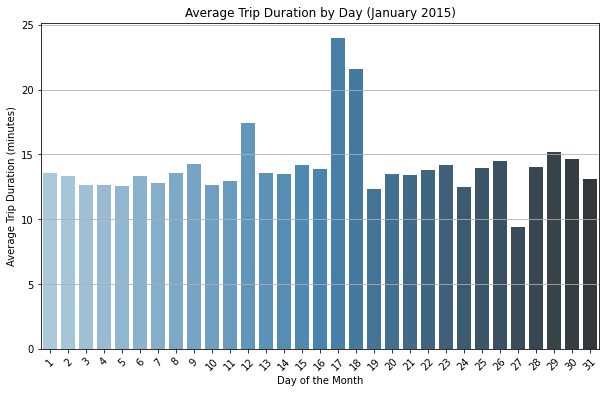

In [0]:
from pyspark.sql.functions import dayofmonth

data2015_1c = data2015_1c.withColumn('day', dayofmonth('tpep_pickup_datetime'))
trend = data2015_1c.groupBy('day') \
    .agg(avg('trip_duration').alias('avg_trip_duration')) \
    .orderBy('day').toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='day', y='avg_trip_duration', data=trend, palette = 'Blues_d')
plt.title('Average Trip Duration by Day (January 2015)')
plt.xlabel('Day of the Month')
plt.ylabel('Average Trip Duration (minutes)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()






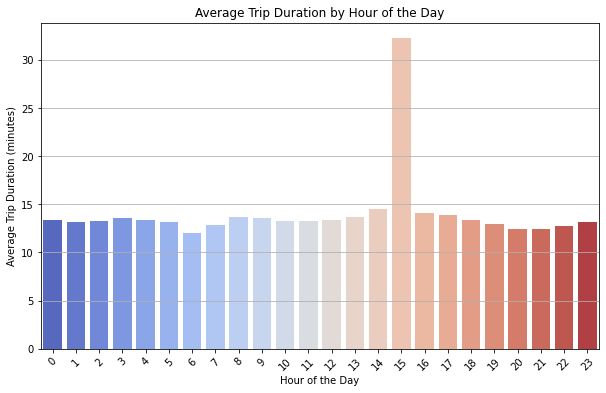

In [0]:
hourly_trip_duration = data2015_1c.groupBy('pickup_hour') \
    .agg(avg('trip_duration').alias('avg_trip_duration')) \
    .orderBy('pickup_hour').toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='pickup_hour', y='avg_trip_duration', data=hourly_trip_duration, palette='coolwarm')
plt.title('Average Trip Duration by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Trip Duration (minutes)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
